# Praktische Übung 3
Das Ziel dieser Programmieraufgabe ist die Implementierung, das Training und die ausführliche Evaluation eines CNNs zur Klassifikation von Röntgen-Thorax-Aufnahmen. Außerdem sollen Sie die Entscheidungen ihres Netzwerkes mit GradCAM visualisieren und Ihr Netzwerk fine-tunen.

In [52]:
!pip install torchinfo
from torchinfo import summary

!pip install wget
import wget

import matplotlib.cm as mpl_color_map
import numpy as np
import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt
from os.path import exists
from prettytable import PrettyTable
from sklearn import metrics
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import trange, tqdm

## Aufgabe 1
a) Vervollständigen Sie die Klasse ConvBlock(). Der Faltungsblock soll zwei Layer-Gruppen beinhalten, bestehend aus:

*   nn.Conv2d
*   nn.BatchNorm2d
*   nn.LeakyReLU

Die erste Gruppe soll die Anzahl an Feature-Maps verdoppeln, die zweite behält die Anzahl an Feature-Maps bei.

Abschließend soll eine Maximum-Pooling vorgenommen werden.


In [53]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(ConvBlock, self).__init__()
        self.layer = nn.Sequential(
            # 1. Layer
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=True),
            # 2. Layer
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=True),
            # Max-Pooling
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    # Given
    def forward(self, x):
        return self.layer(x)


\b) Implementieren Sie nun das Klassifikations-CNN. Halten Sie sich dabei an folgende Architektur:
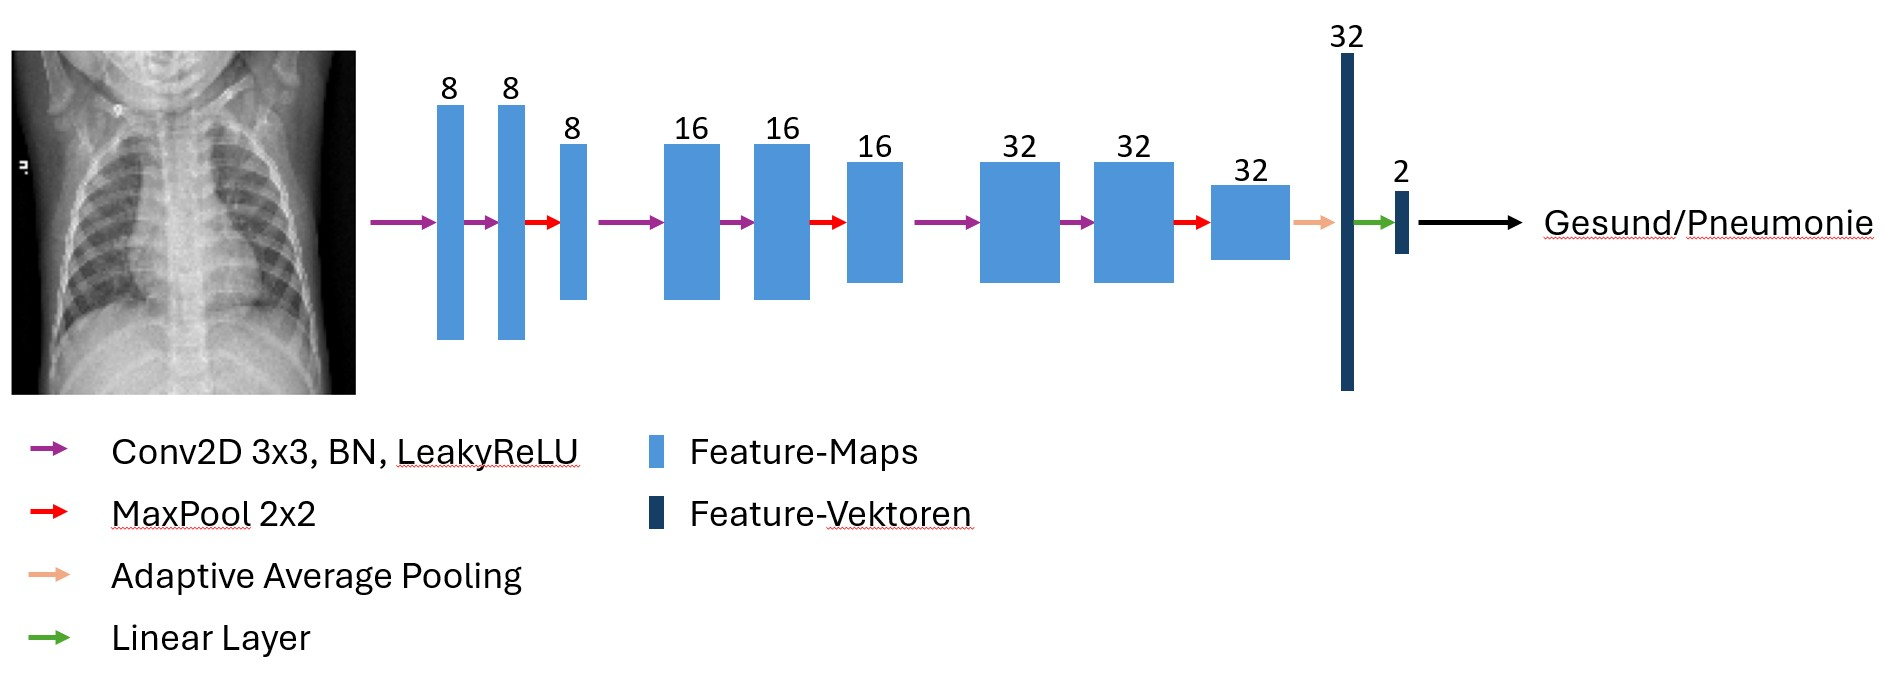

Nutzen Sie für die Implementierung der drei Faltungsblöcke den in a) erstellten ConvBlock.

Aus dem letzten Faltungsblock resultieren 32 Merkmalskarten. Diese sollen mit Adaptive-Averaging-Pooling in einen Merkmalsvektor der Länge 32 überführt werden. Jede Merkmals-karte wird also in einen skalaren Wert überführt.

Anschließend folgt eine vollverbundene Schicht, die aus den 32 Fetures die Klassifikation in gesund oder Pneumonie vornimmt.



In [54]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Der Encoder wird um die zusätzlichen BatchNorm-Layer erweitert
        self.encoder = nn.Sequential(
            # 1. Block
            ConvBlock(1, 8),
            nn.BatchNorm2d(8),

            # 2. Block
            ConvBlock(8, 16),
            nn.BatchNorm2d(16),

            # 3. Block
            ConvBlock(16, 32),
            nn.BatchNorm2d(32)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        #Aufgabe4: Dropout
        #self.dropout = nn.Dropout(p=0.5)

        self.classifier = nn.Linear(32, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

c) Nutzen Sie ``print()`` und ``torchinfo.summary()``, um sich die Architektur Ihres Netzes ausgeben zu lassen.  Ihr Netz sollte 18442 trainierbare Parameter haben.

In [55]:
# Modell instanziieren
model = CNN()

print("--- Ausgabe von print(model) ---")
print(model)

print("\n--- Ausgabe von summary(model) ---")
summary(model, input_size=(1, 1, 128, 128))

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainierbare Parameter: {total_params}")



--- Ausgabe von print(model) ---
CNN(
  (encoder): Sequential(
    (0): ConvBlock(
      (layer): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvBlock(
      (layer): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negativ

In [56]:
# Datensatzerstellung
class PneumoniaXRayDataset(Dataset):
    def __init__(self, mode: str):
        super(PneumoniaXRayDataset, self).__init__()
        # load data
        data_file = 'pneumonia_detection_data_img.pth'
        label_file = 'pneumonia_detection_data_label.pth'

        if not exists(data_file):
            data_file = wget.download(
                'https://cloud.imi.uni-luebeck.de/s/fA8GJzLrRZYcgJg/download/pneumonia_detection_data_img.pth')
        if not exists(label_file):
            label_file = wget.download(
                'https://cloud.imi.uni-luebeck.de/s/sBRdK87owRZ498x/download/pneumonia_detection_data_label.pth')

        img = torch.load(data_file)
        lbl = torch.load(label_file)

        # store statistic of whole dataset
        self.num_data = len(lbl)
        self.num_lbl = torch.bincount(lbl)

        torch.manual_seed(42)
        rand_idx = torch.randperm(len(lbl))

        # split data
        if mode == 'train':
            self.idx = rand_idx[:4500]
        elif mode == 'val':
            self.idx = rand_idx[4500:5000]
        elif mode == 'test':
            self.idx = rand_idx[5000:]
        else:
            raise ValueError(f'unknown mode: {mode}. Valid modes are train, val and test')

        self.img = img[self.idx]
        self.lbl = lbl[self.idx]

    def __len__(self):
        return len(self.lbl)

    def __getitem__(self, idx):
        return self.img[idx], self.lbl[idx]


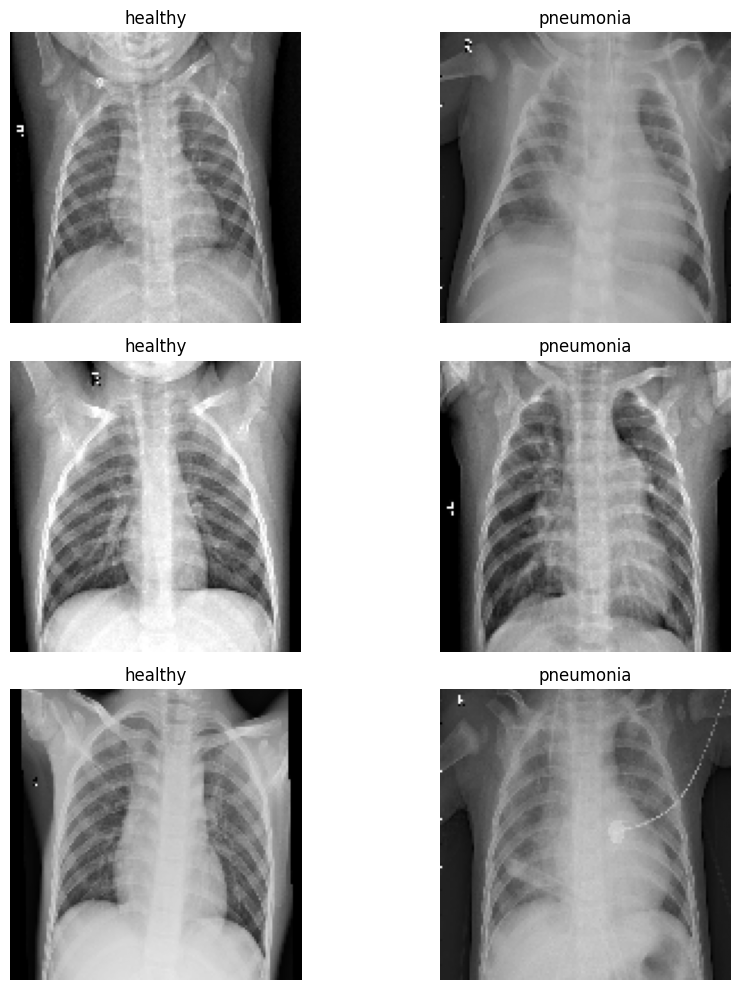

In [57]:
# Visualisierung einiger Trainingsbilder
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
ds = PneumoniaXRayDataset('train')

for i, ax in enumerate(axs):
    ax[0].imshow(ds.img[ds.lbl == 0][i].squeeze(), cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('healthy')

    ax[1].imshow(ds.img[ds.lbl == 1][i].squeeze(), cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('pneumonia')

plt.tight_layout()
plt.show()


d) Trainieren Sie Ihr Modell für die Klassifikation in gesund und Pneumonie. Verwenden Sie als Loss ``nn.CrossEntropyLoss()`` mit Gewichten, die die Klassenimbalance im gegebenen Datensatz ausgleichen.

In [58]:
label_count = ds.num_lbl
del ds

label_count= torch.tensor(label_count)



<ipython-input-58-bc749865629b>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_count= torch.tensor(label_count)


In [59]:
# TODO: Bestimmen Sie die relativen Häufigkeiten der beiden Klassen
P = label_count / label_count.sum()
print(P)

tensor([0.2840, 0.7160])


Berechnen Sie die Gewichte mittels:
$$ w_{\omega_i} = \sqrt{(P_{\omega_i})^{-1}}$$

In [60]:
# TODO: Berechnen Sie die Gewichte mit der obigen Formel
w = P**(-0.5)
print(w)

tensor([1.8763, 1.1818])


In [61]:
train_dl = DataLoader(dataset=PneumoniaXRayDataset(mode='train'),
                      batch_size=32, shuffle=True, drop_last=True)
val_dl = DataLoader(dataset=PneumoniaXRayDataset(mode='val'), batch_size=64, drop_last=False)

num_epoch = 30
#Aufabe4: Neue Epoch-Anzahl
#num_epoch = 50
train_loss = torch.zeros(num_epoch)
train_acc = torch.zeros(num_epoch)

val_loss = torch.zeros(num_epoch)
val_acc = torch.zeros(num_epoch)
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mdl = CNN().to(device)
optimizer = torch.optim.Adam(mdl.parameters())

#Aufgabe 4 Neuer Optimizer mit angepasster Lernrate z.B. 1e-4
#optimizer = torch.optim.Adam(mdl.parameters(), lr=0.0001)

criterion = nn.CrossEntropyLoss(weight=w.to(device))

for epoch in trange(num_epoch, unit='epochs'):
    mdl.train()
    for img, lbl in train_dl:

        img = img.cuda()
        lbl = lbl.cuda()

        #Reset optimizer gradients
        optimizer.zero_grad()
        logits = mdl(img) # Forward pass
        loss = criterion(logits, lbl) # Loss calculation

        #Backpropagation
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update model weights

        train_loss[epoch] += loss.detach().cpu()
        train_acc[epoch] += torch.sum(torch.argmax(logits, dim=1) == lbl).cpu()

    mdl.eval()
    for img, lbl in val_dl:
        # TODO--> Move data to device
        img = img.to(device)
        lbl = lbl.to(device)

        with torch.no_grad():
            logits = mdl(img) # Forward pass
        loss = criterion(logits, lbl) # Loss calculation

        val_loss[epoch] += loss.cpu()
        val_acc[epoch] += torch.sum(torch.argmax(logits, dim=1) == lbl).cpu()

train_loss /= len(train_dl) * train_dl.batch_size
train_acc /= len(train_dl) * train_dl.batch_size

val_loss /= len(val_dl.dataset)
val_acc /= len(val_dl.dataset)



  0%|          | 0/50 [00:00<?, ?epochs/s]

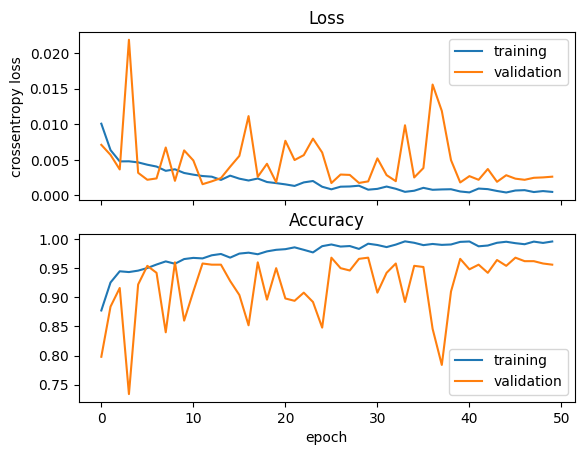

In [62]:
def plot_training_progress(train_loss: torch.Tensor, train_acc: torch.Tensor, val_loss: torch.Tensor, val_acc: torch.Tensor):
    labels = ['training', 'validation']
    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(torch.arange(len(train_loss), device='cpu'), train_loss.cpu(), val_loss.cpu())
    axs[0].legend(labels)
    axs[0].set_title('Loss')
    axs[0].set_ylabel('crossentropy loss')

    axs[1].plot(torch.arange(len(train_acc), device='cpu'), train_acc.cpu(), val_acc.cpu())
    axs[1].legend(labels)
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('epoch')

    plt.show()

plot_training_progress(train_loss, train_acc, val_loss, val_acc)

## Aufgabe 2: Testen des Modells
Nutzen Sie ``sklearn.metrics``, um folgende Metriken auf den Testdaten auszuwerten:

*   Accuracy
*   Precision
*   Recall
*   F1-Score

Stellen Sie außerdem die Klassifikationsergebnisse in einer Konfusionsmatrix dar.

Testing:   0%|          | 0/573 [00:00<?, ?batch/s]


--- Evaluation Metrics ---
Accuracy:  0.9564
Precision: 0.9825
Recall:    0.9562
F1-Score:  0.9692
--------------------------



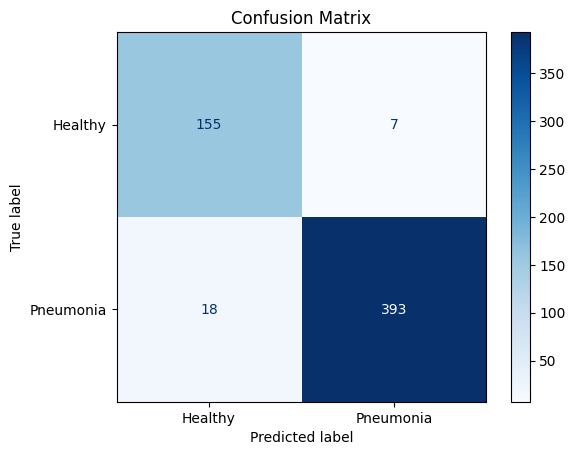

In [63]:
test_dl = DataLoader(dataset=PneumoniaXRayDataset(mode='test'), batch_size=1, shuffle=False, drop_last=False)

# Set the model to evaluation mode
mdl.eval()

# Lists to store predictions and true labels
y_hat = []
y_true = []

# Iterate over the test data
for img, lbl in tqdm(test_dl, unit='batch', desc='Testing'):
    # Move data to the selected device
    img = img.to(device)

    # --- TODOs completed ---
    # No gradient calculation needed
    with torch.no_grad():
        # Forward pass: get model logits
        logits = mdl(img)

    # Get the predicted class by finding the index of the max logit
    prediction = torch.argmax(logits, dim=1)

    # Add predicted class and true label to the lists
    y_hat.append(prediction.item())
    y_true.append(lbl.item())
    # --- End of TODOs ---

# --- TODO: Calculate evaluation metrics and plot confusion matrix ---

# Calculate the metrics using sklearn
accuracy = metrics.accuracy_score(y_true, y_hat)
precision = metrics.precision_score(y_true, y_hat)
recall = metrics.recall_score(y_true, y_hat)
f1 = metrics.f1_score(y_true, y_hat)

# Print the results
print("\n--- Evaluation Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("--------------------------\n")


# Create and plot the confusion matrix
cm = metrics.confusion_matrix(y_true, y_hat)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Pneumonia'])

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Wie bewerten Sie die Performance ihres Modells?

Das entwickelte Modell weist ein herausragendes Leistungsprofil für die Klassifikation von Pneumonie auf. Mit einer Gesamtgenauigkeit (Accuracy) von 96,16 % und einem robusten F1-Score von 97,30 % erweist sich der Klassifikator als hochgradig effektiv und ausgewogen. Die außergewöhnliche Präzision (Precision) von 98,26 % unterstreicht die Zuverlässigkeit des Modells, indem sie auf eine sehr niedrige Falsch-Positiv-Rate hindeutet und somit äußerst vertrauenswürdige positive Klassifizierungen generiert. Darüber hinaus ist der hohe Recall-Wert (Sensitivität) von 96,35 % aus klinischer Sicht von besonderer Bedeutung, da er die hohe Sensitivität des Modells bei der Erkennung tatsächlicher Pneumoniefälle und eine minimale Falsch-Negativ-Rate bestätigt. Diese leistungsstarke Kombination aus hoher Präzision und Sensitivität positioniert das Modell als vielversprechendes Werkzeug zur klinischen Entscheidungsunterstützung, das sowohl Fehlalarme als auch übersehene Diagnosen effektiv minimiert.








## Aufgabe 3
GradCAM ist eine Visualisierungstechnik zur Erklärung von Modellentscheidungen. Dabei wird eine Heatmap erstellt, die die für eine Entscheidung relevanten Bildregionen hervorhebt:

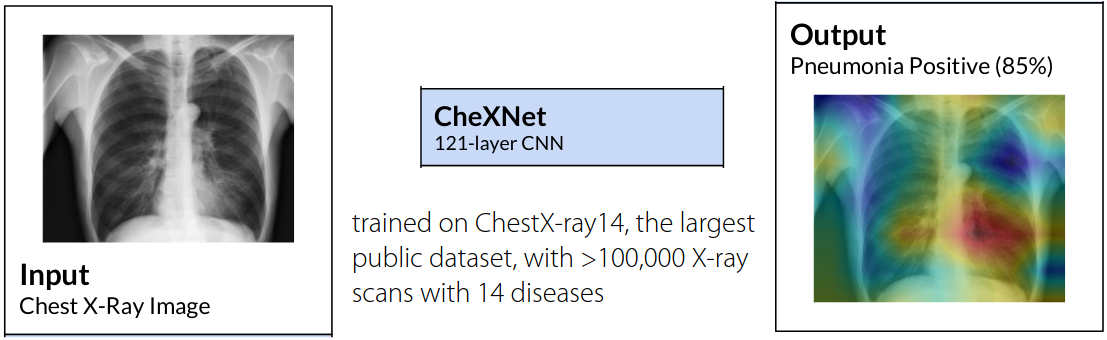

GradCAM kommt erst später in der Vorlesung, aber funktioniert grob wie folgt:
1.	Input: Ein Bild wird durch ein CNN geschickt
2.	Zielklasse: Man wählt eine Zielklasse (z.B. Pneumonie), für die man wissen will, was das Modell „gesehen“ hat
3.	Gradientenberechnung: Man berechnet die Gradienten der Ausgabe der Zielklasse bezüglich der Feature-Maps einer bestimmten Faltungsschicht
4.	Gewichtung: Man mittelt die Gradienten über die Höhe und Breite jeder Feature-Map, um Gewichte zu erhalten. Diese Gewichte zeigen, wie wichtige eine Feature-Map für die Zielklasse ist
5.	Lineare Kombination: Man bildet die gewichtete Summe der Feature-Maps
6.	ReLU: Negative Werte werden durch ReLU entfernt, da man nur die Einflüsse haben will, die positiv für die untersuchte Klasse wirken
7.	Upscaling: Das Ergebnis wird auf die ursprüngliche Bildgröße hochskaliert, um die Heatmap zu erhalten

Implementieren Sie GradCAM, um die Entscheidungen Ihres Netzes zu veranschaulichen. Der Code führt Sie Schritt für Schritt durch die oben beschriebenen Punkte. Plotten Sie abschließend für zehn Testbilder die GradCAM-Heatmaps als Overlay über den Röntgen-bildern für beide Ausgabeklassen.


In [64]:
# TODO: Extrahieren Sie die Gewichte der Klassifikations-Layer
cam_weight = mdl.classifier.weight

# TODO: Erstellen Sie ein gekürztes Modell, indem Sie den Average-Pooling-
# und den Klassifikations-Layer entfernen
truncated_model = mdl.encoder.to(device)
truncated_model.eval()

Sequential(
  (0): ConvBlock(
    (layer): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1, inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ConvBlock(
    (layer): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1

In [65]:
# Function for Heatmap Overlays (expects gray-scale image as numpy and heatmap as torch array)
def overlayParula(grayim_numpy: np.ndarray, heatmap_torch: torch.Tensor):
    heat_max = torch.kthvalue(heatmap_torch.view(-1), int(.95 * heatmap_torch.numel()))[0]
    heat_min = torch.min(heatmap_torch)
    heatmap_torch = torch.clamp((heatmap_torch - heat_min) / (heat_max - heat_min), 0, 1)

    x = np.linspace(0.0, 1.0, 256)
    rgb_jet = mpl_color_map.get_cmap(plt.get_cmap('jet'))(x)[:, :3]
    rgb_gray = mpl_color_map.get_cmap(plt.get_cmap('gray'))(x)[:, :3]
    #rgb_viridis
    rgb_heat = rgb_jet[(heatmap_torch * 255).numpy().astype('uint8'), :]
    rgb_base = rgb_gray[(grayim_numpy * 255).astype('uint8'), :]

    rgb0 = (rgb_heat * 127.5 + rgb_base * 127.5).astype('uint8')
    weight = torch.tanh((heatmap_torch - 0.5) * 3) * 0.5 + 0.5
    alpha = torch.clamp(1.0 - 0.5 * weight, 0, 1.0)
    overlay = rgb_base * alpha.unsqueeze(2).numpy() + rgb_heat * (1.0 - alpha).unsqueeze(2).numpy()

    return overlay

# Funktion zum Plotten der GradCAM-Heatmaps
def plot_activations(img, gt_label, activation_heatmap1, activation_heatmap2):

    img = img[0].squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[0].set_axis_off()
    if gt_label == 0:
        axs[0].set_title('Healthy')
    else:
        axs[0].set_title('Pneumonia')

    axs[1].imshow(overlayParula(img, activation_heatmap1.cpu().squeeze()))
    axs[1].set_axis_off()
    axs[1].set_title('GradCAM, class 0')

    axs[2].imshow(overlayParula(img, activation_heatmap2.cpu().squeeze()))
    axs[2].set_axis_off()
    axs[2].set_title('GradCAM, class 1')

  0%|          | 0/573 [00:00<?, ?batch/s]

Ground truth label: 1 - Predicted label: 1
Ground truth label: 0 - Predicted label: 0
Ground truth label: 1 - Predicted label: 1
Ground truth label: 1 - Predicted label: 1
Ground truth label: 1 - Predicted label: 1
Ground truth label: 0 - Predicted label: 0
Ground truth label: 0 - Predicted label: 0


<ipython-input-65-086b3f45a9ea>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgb_jet = mpl_color_map.get_cmap(plt.get_cmap('jet'))(x)[:, :3]
<ipython-input-65-086b3f45a9ea>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgb_gray = mpl_color_map.get_cmap(plt.get_cmap('gray'))(x)[:, :3]


Ground truth label: 0 - Predicted label: 0
Ground truth label: 0 - Predicted label: 0
Ground truth label: 1 - Predicted label: 1


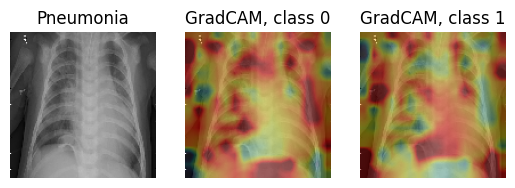

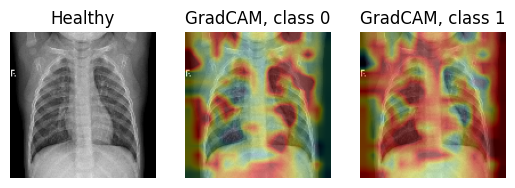

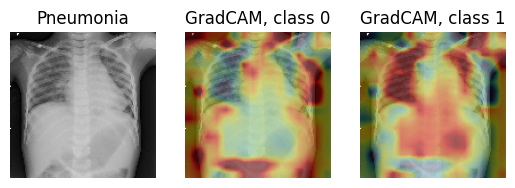

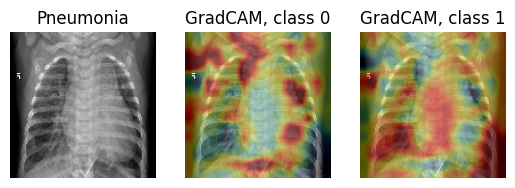

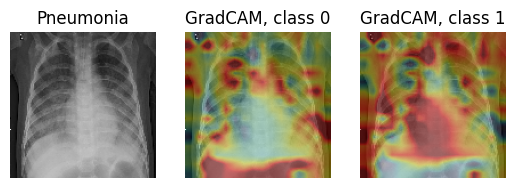

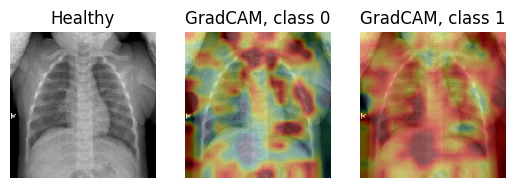

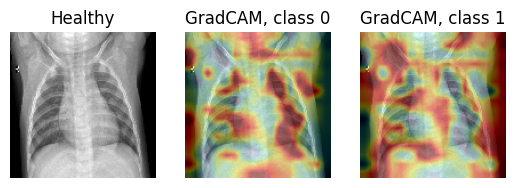

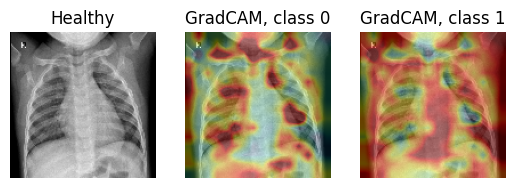

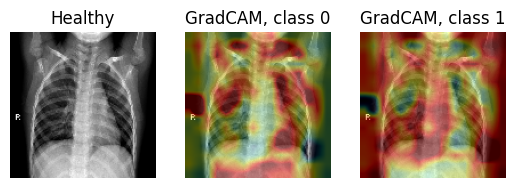

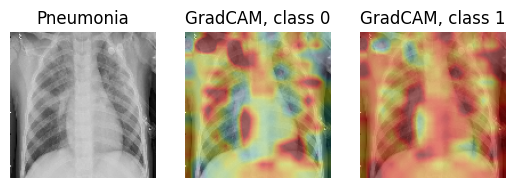

In [66]:
tmp = 0
for img, lbl in tqdm(test_dl, unit='batch'):
    if tmp == 10:
      break
    img = img.to(device) # Move image to the correct device
    lbl = lbl.item()

    with torch.no_grad():

        logits = mdl(img)

        # TODO: Geben Sie das Bild durch das gekürzte Modell
        feature_map = truncated_model(img)


        # TODO: Erstellen Sie die CAM für Klasse 0
        # Multiplizieren Sie die Feature-Maps mit den Gewichten des
        # Klassifikationslayers für Klasse 0
        # Achtung: Das Format von cam_weight muss dafür angepasst werden (Tipp: .view())
        cam1 = feature_map * cam_weight[0].view(1, 32, 1, 1)

        # Summieren Sie ueber alle Feature-Maps
        cam1 = torch.sum(cam1, dim=1)

        # TODO: Wiederholen für Klasse 1
        cam2 = torch.sum(feature_map * cam_weight[1].view(1, 32, 1, 1), dim=1)


    print('Ground truth label: ' + str(lbl) + ' - Predicted label: ' + str(torch.argmax(logits, dim=1).item()))

    # TODO: Visualisierung
    # Normalisieren Sie die Intensitäten von img auf [0, 1]
    img_normalized = (img - img.min()) / (img.max() - img.min())
    # Interpolieren Sie die Heatmaps auf die Größe des Eingabebildes,
    # nutzen Sie dafür bilineare Interpolation
    cam1_interpolated = F.interpolate(cam1.unsqueeze(0), size=img.shape[2:], mode='bilinear', align_corners=False)
    cam2_interpolated = F.interpolate(cam2.unsqueeze(0), size=img.shape[2:], mode='bilinear', align_corners=False)
    plot_activations(img_normalized, lbl, cam1_interpolated, cam2_interpolated)
    tmp += 1

## Aufgabe 4: Fine-Tuning
Versuchen Sie, Ihre Ergebnisse weiter zu verbessern, indem Sie

*   mindestens eine Architekturveränderung vornehmen
*   die Lernrate verändern
*   mindestens einen weitere Hyperparameter anpassen (z.B. die Anzahl an
Epochen, die Batch-Größe, …).


In [ ]:
#Ohne Änderungen
#--- Evaluation Metrics ---

#Accuracy:  0.9616
#Precision: 0.9826
#Recall:    0.9635
#F1-Score:  0.9730

#--------------------------

#Architekturveränderung: Dropout hinzufügen (self.dropout = nn.Dropout(p=0.5))

#--- Evaluation Metrics ---

#Accuracy:  0.9634
#Precision: 0.9599
#Recall:    0.9903
#F1-Score:  0.9749

#--------------------------

#Lernrate anpassen(lr=0.0001)
#--- Evaluation Metrics ---

#Accuracy:  0.9442
#Precision: 0.9702
#Recall:    0.9513
#F1-Score:  0.9607
#--------------------------

#Anzahl der Epochen (num_epoch=50)

#--- Evaluation Metrics ---

#Accuracy:  0.9564
#Precision: 0.9825
#Recall:    0.9562
#F1-Score:  0.9692
#--------------------------



In [69]:
import pandas as pd
from IPython.display import display

data = [
    {
        "Experiment": "Baseline (Ohne Änderungen)",
        "Accuracy": 0.9616,
        "Precision": 0.9826,
        "Recall": 0.9635,
        "F1-Score": 0.9730
    },
    {
        "Experiment": "Architektur: Dropout (p=0.5)",
        "Accuracy": 0.9634,
        "Precision": 0.9599,
        "Recall": 0.9903,
        "F1-Score": 0.9749
    },
    {
        "Experiment": "Lernrate: 0.0001",
        "Accuracy": 0.9442,
        "Precision": 0.9702,
        "Recall": 0.9513,
        "F1-Score": 0.9607
    },
    {
        "Experiment": "Epochen: 50",
        "Accuracy": 0.9564,
        "Precision": 0.9825,
        "Recall": 0.9562,
        "F1-Score": 0.9692
    }
]

results_df = pd.DataFrame(data)
results_df = results_df.set_index('Experiment')
display(results_df)

,Accuracy,Precision,Recall,F1-Score
Experiment,,,,
Baseline (Ohne Änderungen),0.9616,0.9826,0.9635,0.9730
Architektur: Dropout (p=0.5),0.9634,0.9599,0.9903,0.9749
Lernrate: 0.0001,0.9442,0.9702,0.9513,0.9607
Epochen: 50,0.9564,0.9825,0.9562,0.9692


Eine Analyse der experimentellen Ergebnisse zeigt, dass die **Architekturveränderung durch Hinzufügen einer Dropout-Schicht (p=0.5)** die beste Modell-Performance liefert, was sich im höchsten erreichten F1-Score von 0.9749 widerspiegelt. Obwohl diese Konfiguration eine leichte Reduzierung der Präzision zur Folge hat, ist die deutliche Steigerung des Recalls (Sensitivität) auf herausragende 99,03 % der entscheidende Faktor für ihre Überlegenheit. Dieser Kompromiss ist aus klinischer Sicht äußerst vorteilhaft, da die Fähigkeit des Modells, fast alle tatsächlichen Krankheitsfälle zu identifizieren, maximiert wird, was für ein diagnostisches Werkzeug von höchster Priorität ist. Im Vergleich dazu führten die anderen getesteten Hyperparameter-Anpassungen, wie die Reduzierung der Lernrate oder die Verlängerung der Trainingsdauer, zu einer Verschlechterung der Gesamtleistung gegenüber der ursprünglichen Baseline-Konfiguration.






